In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S

Using the BEX models from Linder et al (2019) as well as the AMES-COND grid (Allard et al. 2001), determine the fluxes in a given filter with respect to exoplanet mass and age. Also, show contrasts relative to some primary host star.

In [3]:
def get_planet_counts(bp, age, masses=[0.1,1,10], dist=10, model='linder', file=None,
                      return_mags=False):
    
    if 'linder' in model.lower():
        tbl = nrc_utils.linder_table(file)
        res = nrc_utils.linder_filter(tbl, bp.name, age, dist=dist, 
                                      cond_interp=True, cond_file=None)
    elif 'cond' in model.lower():
        tbl = nrc_utils.cond_table(age, file)
        res = nrc_utils.cond_filter(tbl, bp.name, dist=dist)
        
    else:
        raise ValueError("model name {} not recognized".format(model))
    
    # Arrays of masses and magnitudes
    mass_vals, mag_vals = res
    # Sort by mass
    isort = np.argsort(mass_vals)
    mass_data = mass_vals[isort]
    mag_data = mag_vals[isort]
    
    # Interpolate masses in log space to get a linear function
    xv, yv = np.log10(mass_data[isort]), mag_data[isort]
    xint = np.log10(masses)
    mags = np.interp(xint, xv, yv)
    
    if return_mags:
        return mags
    
    # Convert mags into counts for this bandpass
    count_arr = []
    sp = pynrc.stellar_spectrum('flat')
    for i, mass in enumerate(masses):
        # Renormalize to magnitude of each planet and get count rate
        sp_norm = sp.renorm(mags[i], 'vegamag', bp)
        obs = S.Observation(sp_norm, bp, binset=bp.wave)
        count_arr.append(obs.countrate())

    return np.array(count_arr)

# BEX Models for Medium Filters

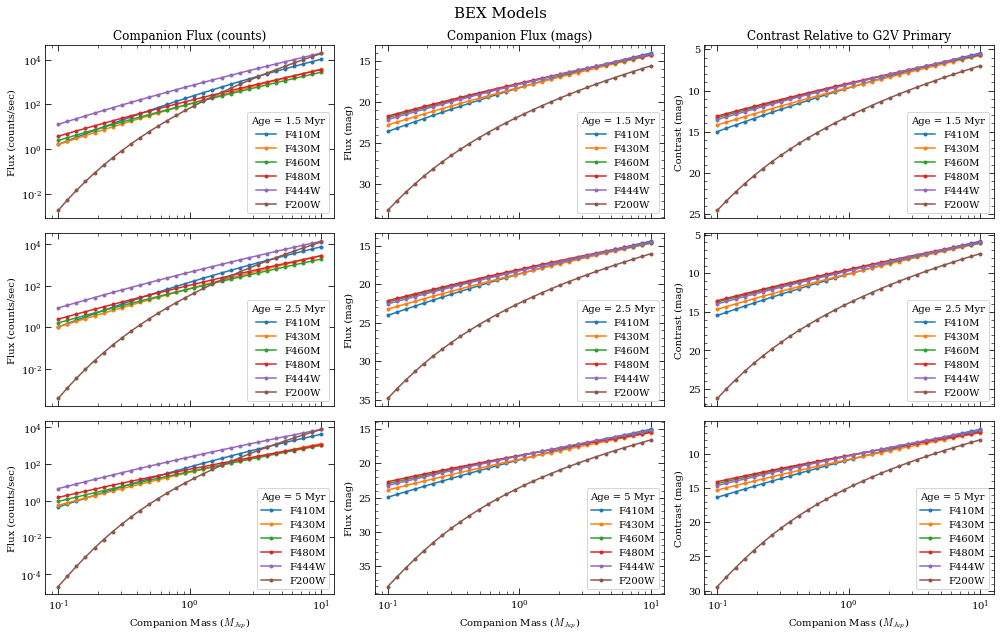

In [7]:
fig, axes_all = plt.subplots(3,3,figsize=(14,9),sharex=True)

ages = [1.5, 2.5, 5] # Myr
mass_min, mass_max = (0.1, 10)  # MJup
masses = np.logspace(np.log10(mass_min),np.log10(mass_max),num=30)
filters = ['F410M', 'F430M', 'F460M', 'F480M', 'F444W', 'F200W']

# Normalize a G2V star to it's K-Band absolute magnitude
bp_k = pynrc.bp_2mass('k')
kmag = 8.6
spt = 'G2V'
sp_star = pynrc.stellar_spectrum(spt, kmag, 'vegamag', bp_k)
# spt = 'K5V'
# sp_star = pynrc.stellar_spectrum(spt, 3.2, 'vegamag', bp_k)


model = 'linder'

for i, age in enumerate(ages):
    axes = axes_all[i]
    
    for filt in filters:
        bp = nrc_utils.read_filter(filt, module='B')

        res = get_planet_counts(bp, age, masses, return_mags=False, model=model, dist=158)    
        axes[0].loglog(masses, res, marker='.', label=filt)

        res = get_planet_counts(bp, age, masses, return_mags=True, model=model, dist=158)
        axes[1].semilogx(masses, res, marker='.', label=filt)

        obs = S.Observation(sp_star, bp, bp.wave)
        # print(obs.effstim('vegamag'))
        axes[2].semilogx(masses, res - obs.effstim('vegamag'), marker='.', label=filt)

    axes[0].set_ylabel("Flux (counts/sec)")
    axes[1].set_ylabel("Flux (mag)")
    axes[2].set_ylabel("Contrast (mag)")
    if i==0: 
        axes[0].set_title(f"Companion Flux (counts)")
        axes[1].set_title(f"Companion Flux (mags)")
        axes[2].set_title(f"Contrast Relative to {spt} Primary")

    
    for j, ax in enumerate(axes):
        if j>0:
            ax.set_ylim(ax.get_ylim()[::-1])
        ax.legend(title=f'Age = {age} Myr', loc='lower right')
        if i==2: 
            ax.set_xlabel('Companion Mass ($M_{Jup}$)')
            
            
mod_str = 'BEX' if model=='linder' else 'COND'
fig.suptitle(f'{mod_str} Models', fontsize=15)
    
fig.tight_layout()

# COND Models for Medium Band Filters

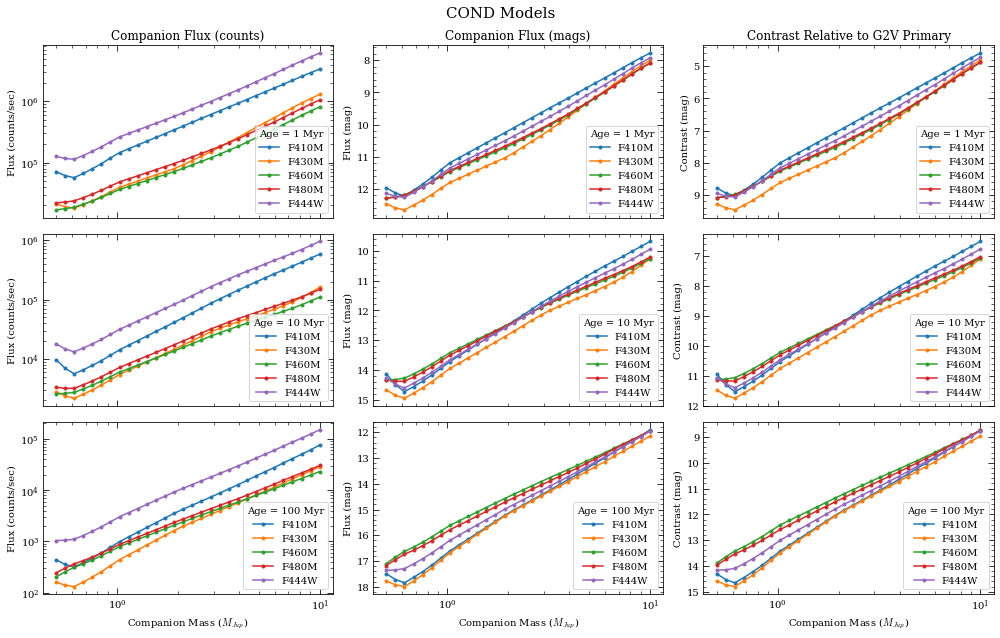

In [5]:
fig, axes_all = plt.subplots(3,3,figsize=(14,9),sharex=True)

ages = [1, 10, 100] # Myr
mass_min, mass_max = (0.5, 10)  # MJup
masses = np.logspace(np.log10(mass_min),np.log10(mass_max),num=30)
filters = ['F410M', 'F430M', 'F460M', 'F480M', 'F444W']

# Normalize a G2V star to it's K-Band absolute magnitude
bp_k = pynrc.bp_2mass('k')
spt = 'G2V'
sp_star = pynrc.stellar_spectrum(spt, 3.2, 'vegamag', bp_k)

model = 'cond'

for i, age in enumerate(ages):
    axes = axes_all[i]
    
    for filt in filters:
        bp = nrc_utils.read_filter(filt, module='B')

        res = get_planet_counts(bp, age, masses, return_mags=False, model=model)    
        axes[0].loglog(masses, res, marker='.', label=filt)

        res = get_planet_counts(bp, age, masses, return_mags=True, model=model)
        axes[1].semilogx(masses, res, marker='.', label=filt)

        obs = S.Observation(sp_star, bp, bp.wave)
        axes[2].semilogx(masses, res - obs.effstim('vegamag'), marker='.', label=filt)

    axes[0].set_ylabel("Flux (counts/sec)")
    axes[1].set_ylabel("Flux (mag)")
    axes[2].set_ylabel("Contrast (mag)")
    if i==0: 
        axes[0].set_title(f"Companion Flux (counts)")
        axes[1].set_title(f"Companion Flux (mags)")
        axes[2].set_title(f"Contrast Relative to {spt} Primary")

    
    for j, ax in enumerate(axes):
        if j>0:
            ax.set_ylim(ax.get_ylim()[::-1])
        ax.legend(title=f'Age = {age} Myr', loc='lower right')
        if i==2: 
            ax.set_xlabel('Companion Mass ($M_{Jup}$)')
            
            
mod_str = 'BEX' if model=='linder' else 'COND'
fig.suptitle(f'{mod_str} Models', fontsize=15)
    
fig.tight_layout()

# Linder Models for Wide Band Filters

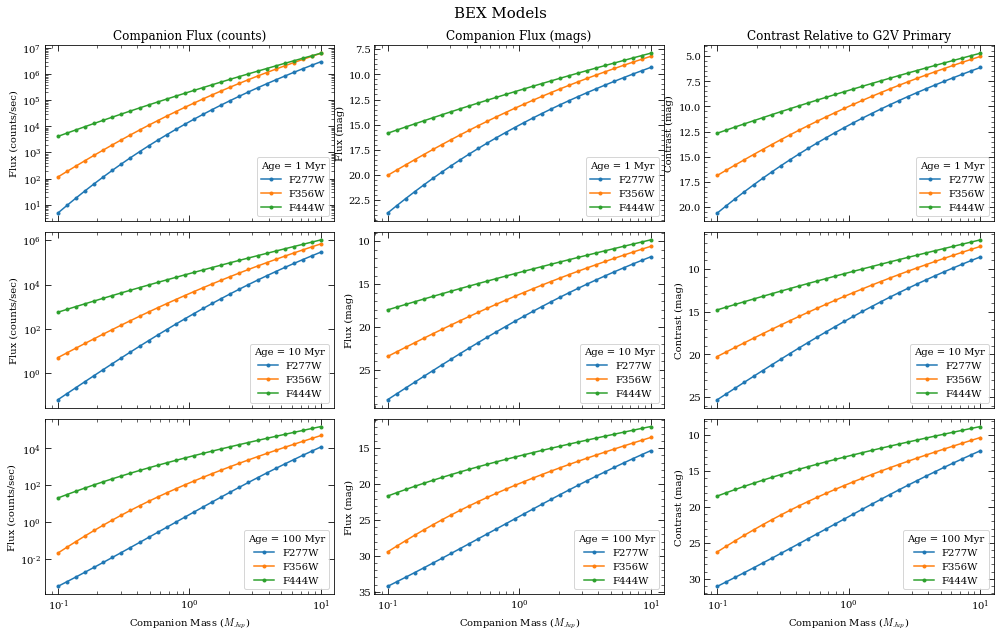

In [6]:
fig, axes_all = plt.subplots(3,3,figsize=(14,9),sharex=True)

ages = [1, 10, 100] # Myr
mass_min, mass_max = (0.1, 10)  # MJup
masses = np.logspace(np.log10(mass_min),np.log10(mass_max),num=30)
filters = ['F277W', 'F356W', 'F444W']

# Normalize a G2V star to it's K-Band absolute magnitude
bp_k = pynrc.bp_2mass('k')
spt = 'G2V'
sp_star = pynrc.stellar_spectrum(spt, 3.2, 'vegamag', bp_k)

model = 'linder'

for i, age in enumerate(ages):
    axes = axes_all[i]
    
    for filt in filters:
        bp = nrc_utils.read_filter(filt, module='B')

        res = get_planet_counts(bp, age, masses, return_mags=False, model=model)    
        axes[0].loglog(masses, res, marker='.', label=filt)

        res = get_planet_counts(bp, age, masses, return_mags=True, model=model)
        axes[1].semilogx(masses, res, marker='.', label=filt)

        obs = S.Observation(sp_star, bp, bp.wave)
        axes[2].semilogx(masses, res - obs.effstim('vegamag'), marker='.', label=filt)

    axes[0].set_ylabel("Flux (counts/sec)")
    axes[1].set_ylabel("Flux (mag)")
    axes[2].set_ylabel("Contrast (mag)")
    if i==0: 
        axes[0].set_title(f"Companion Flux (counts)")
        axes[1].set_title(f"Companion Flux (mags)")
        axes[2].set_title(f"Contrast Relative to {spt} Primary")

    
    for j, ax in enumerate(axes):
        if j>0:
            ax.set_ylim(ax.get_ylim()[::-1])
        ax.legend(title=f'Age = {age} Myr', loc='lower right')
        if i==2: 
            ax.set_xlabel('Companion Mass ($M_{Jup}$)')
            
            
mod_str = 'BEX' if model=='linder' else 'COND'
fig.suptitle(f'{mod_str} Models', fontsize=15)
    
fig.tight_layout()